# Исследование о продаже игр

Интернет-магазине продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. 

## Откроем файл и изучим полную информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head()
# Посмотрим первые 5 строк таблицы

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()
# посмотрим полную информацию о наборе данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.isna().sum()
# Проверим пропуски в столбцах

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

'Общая гистограмма таблицы'

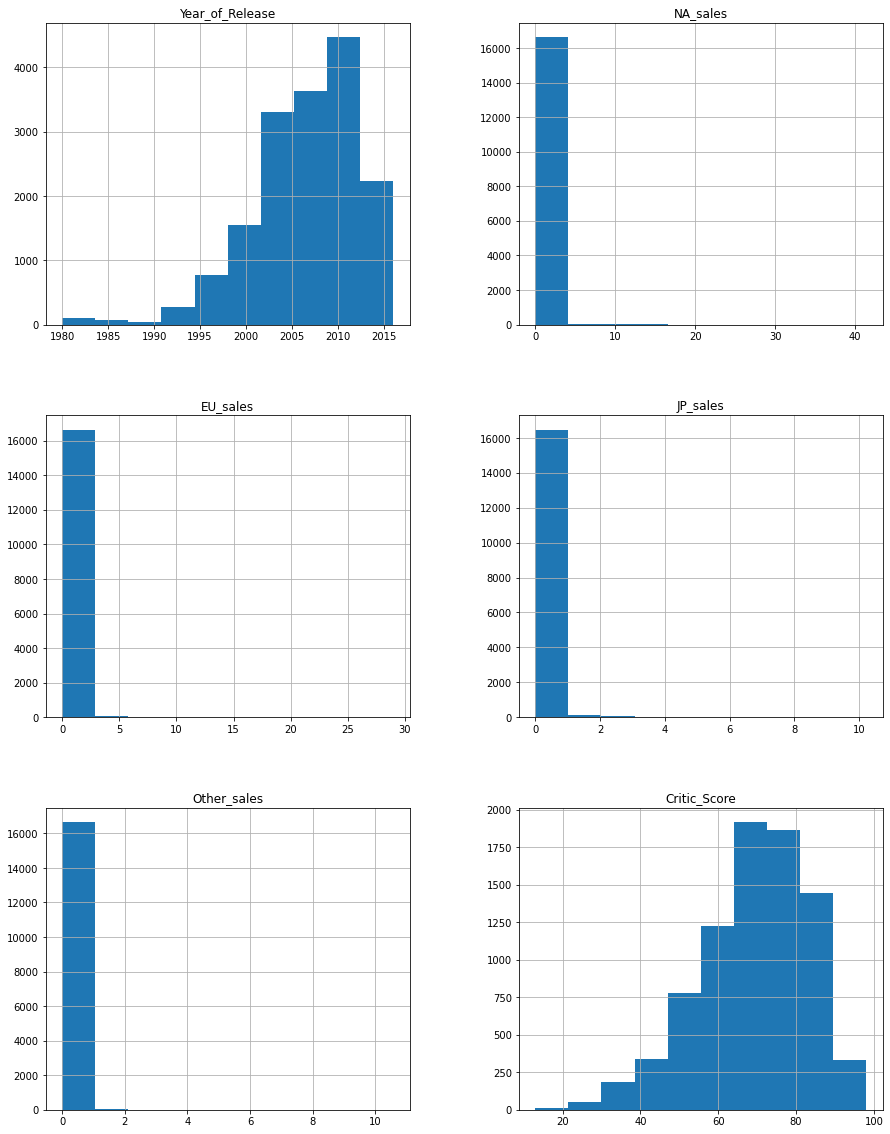

In [6]:
data.hist(figsize=(15, 20))
"Общая гистограмма таблицы"

Отрицательных значений нигде нет и это хорошо) Однако есть много пропущенных значений в столбцах с пользовательскими оценками и оценками критиков, а так же в возрастном рейтинге. Ещё немного пропусков есть в годах выпуска игры, а так же этот столбец имеет не верный формат. И везде втречается верхний регистр, как в названии столбцов, так и в самих данных. Начнём всё это исправлять на следующем этапе. 

## Предобработка данных

### Начнём с преобразования данных в нижний регистр

In [7]:
data.columns = data.columns.str.lower()

In [8]:
data['name'] = data['name'].str.lower()
data['platform'] = data['platform'].str.lower()
data['genre'] = data['genre'].str.lower()

In [9]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Все данные приведены к нижнему регистру, так будет намного удобнее.

### Удалим пропуски, которые невозможно заполнить или пропустить по какой-либо логике, это названия игр и год выпуска.

Конечно же можно было заполнить пропуски в дате выхода данными из интернета, однако 269 игр искать достаточно долго, а на вывод врядли повляет такой незначительный процент.

In [10]:
data = data.dropna(subset=['name', 'year_of_release', 'genre'])

### Проверим дубликаты и уникальные названия по некоторым столбцам, на всякий случай.

In [11]:
data['platform'].unique()

array(['wii', 'nes', 'gb', 'ds', 'x360', 'ps3', 'ps2', 'snes', 'gba',
       'ps4', '3ds', 'n64', 'ps', 'xb', 'pc', '2600', 'psp', 'xone',
       'wiiu', 'gc', 'gen', 'dc', 'psv', 'sat', 'scd', 'ws', 'ng', 'tg16',
       '3do', 'gg', 'pcfx'], dtype=object)

Что удивительно, пришлось гуглить некоторые названия) PC Engine очень странная консоль. А вот повторений здесь нет, всё уникально.

In [12]:
data['name'].duplicated().sum()

5018

Вероятно в каждой строчке есть привязка только к одной платформе, т.е. мультиплатформенные игры указаны несколько раз. Если это правда, некоторые данные нужно будет считать по уникальным значениям. Проверим.

In [13]:
data['name'].sort_values().unique()

array([' beyblade burst', ' fire emblem fates', " frozen: olaf's quest",
       ..., 'zwei!!', 'zyuden sentai kyoryuger: game de gaburincho!!',
       '¡shin chan flipa en colores!'], dtype=object)

In [14]:
data[data['name'] == " frozen: olaf's quest"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3358,frozen: olaf's quest,3ds,2013.0,platform,0.27,0.27,0.0,0.05,NaN,NaN,NaN
3862,frozen: olaf's quest,ds,2013.0,platform,0.21,0.26,0.0,0.04,NaN,NaN,NaN


In [15]:
data[data['name'] == "super mario bros."]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
201,super mario bros.,gb,1999.0,platform,3.40,1.30,0.15,0.22,NaN,NaN,NaN


In [16]:
data[data['name'] == "the witcher 3: wild hunt"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
303,the witcher 3: wild hunt,ps4,2015.0,role-playing,1.02,2.13,0.23,0.59,92.0,9.2,M
1499,the witcher 3: wild hunt,xone,2015.0,role-playing,0.69,0.50,0.00,0.11,91.0,9.2,M
2851,the witcher 3: wild hunt,pc,2015.0,role-playing,0.21,0.46,0.00,0.05,93.0,9.3,M


Так и есть. Данные по выпущенным играм за год лучше всего будет посчитать по уникальным названиям, иначе за последние лет 10 подсчёт сильно исказится.

In [17]:
data['genre'].unique()

array(['sports', 'platform', 'racing', 'role-playing', 'puzzle', 'misc',
       'shooter', 'simulation', 'action', 'fighting', 'adventure',
       'strategy'], dtype=object)

В жанрах повторов так же нет.

### Поменяем тип данных в столбце с годом выхода.

In [18]:
data['year_of_release'] = data['year_of_release'].astype('int')

### Проверим, насколько возможно будет поменять оценки критиков и пользвателей у игр.

Проверим, повлияет ли заполнение пропусков на общую картину, возможно лучше будет их оставить, поскольку оценки игр могут зависит от многих факторов.

In [19]:
data['critic_score'].mean() 
# среднее значение до изменений

68.99436302142053

In [20]:
test_data = data
# переменная для тестирования

In [21]:
test_data[test_data['genre'] == 'action']['critic_score'].mean()

66.67693138843867

In [22]:
test_data[test_data['genre'] == 'action']['critic_score'].mean()

66.67693138843867

In [23]:
test_data['critic_score'].mean()
# среднее значение после изменений

68.99436302142053

Можно сделать вывод о том, что оценки лучше оставить пустыми, ведь их заполнение не сильно влияет на итоговый результат, а вот на исследовании может отразиться не в лучшую сторону, ведь оценки у игр зависят от очень большого количества факторов и неправильные значения могут повлиять на итоговый вывод, а заполнение средними значениями или медианым на него и вовсе не повлияют.

### Теперь изменим тип данных в столбце user_score

Для начала проверим все уникальные значение в столбце.

In [24]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [25]:
data[data['user_score'] == 'tbd']['user_score'].count()
# количество значение 'tbd'

2376

В целом все значения стандартные, кроме 'tbd', так же сам столбец имеет тип object, хотя все остальные данные относятся к float. Необходимо заменить все подобные значения, при этом вряд-ли их можно заменить на какие-то логичные цифры,так что лучше приравнять их к пропускам. К тому же в игровой индустрии аббревиатура TBD означает "будет определено", вероятнее всего у этих игр ещё слишком мало оценок от пользователей. Интересное наблюдение, без замены tbd они принимают очень странные значения при принудительному приведению к новому формату, вероятнее всего это значение суммы (а может и нет) номера букв в python. 

In [26]:
def replace_user_scores(wrong_user_scores, correct_user_score):
    data['user_score'] = data['user_score'].replace(wrong_user_scores, correct_user_score)
replace_user_scores('tbd', np.NaN)

In [27]:
data['user_score'].unique()
# проверим уникальные значения заново

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [28]:
data['user_score'] = data['user_score'].astype('float')

Теперь данные изменены на корректные и с ними можно работать.

### Проверим уникальные значения в столбце с возрастным рейтингом

In [29]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Здесь есть неочевидный дубликат, рейтинг 'K-A' это старое название рейтинга 'E' в системе ESRB. А 'RP' - рейтинг ожидается, это нужно будет учесть при исследовании.

In [30]:
data[data['rating'] == 'K-A']['rating'].count()

3

In [31]:
def replace_rating(old_rating, new_rating):
    data['rating'] = data['rating'].replace(old_rating, new_rating)
replace_rating('K-A', 'E')    

В столбце Rating  так же есть много пропусков и, вероятно, они не случайны, скорее всего эти игры не получили оценок, поскольку могли быть выпущены до того как появилась система ESRB или просто еще не успели их оценить. Их стоит заменить особым значением, например "unknown", чтобы при составлении портрета пользователя не потерять эти данные.


In [32]:
data['rating'] = data['rating'].fillna('unknown')

### Теперь созданим новый столбец с суммарными продажами во всех регионах

In [33]:
data['total_sales'] = data['na_sales'] + data['jp_sales'] + data['eu_sales'] + data['other_sales']

In [34]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


Все данные подготовленны, везде нужные форматы, добавлены новые для исследования. К сожалению,очень много пропусков в информации об оценках пользователей и критиков, то же самое с возрастным рейтингом, эти данные заполнить объективно и правильно не получиться, если их заполнять средними значениями, это не повлияет на исследования и может быть неверно,а искать 8000 игр слишком долго) Пропуски могли появиться из-за того, что данные взяты только из одного источника, например metacritic, где могут содержаться данные не о всех вышедших играх.

## Исследовательский анализ данных

### Для начала посмотрим, сколько игр выпускалось в разные года.

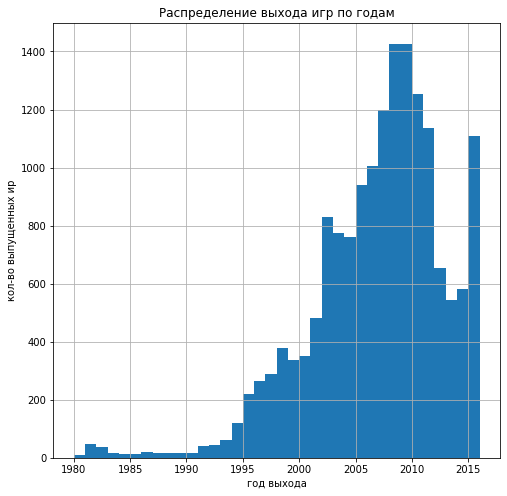

In [36]:
data['year_of_release'].hist(bins=36, figsize=(8, 8)).set_title('Распределение выхода игр по годам')
plt.xlabel('год выхода')
plt.ylabel('кол-во выпущенных ир')
plt.show()

Ожидаемо на графике рост количества выпускаемых игр с начала 90-х годов, виден кризис игровой индустрии 1983 года. Так же наблюдается снижение количества выпускаемых игр с 2010 года. информации об этом не нашёл в интернете, однако нашёл статистики по количеству, и в 2010 действительно был спад выпуска игр. Вероятно это связано с использованием новых технологий в разработке и увелечении среднего срока производства, а ещё примерно в этот же момент практически перестали выходить "AA" игры и стало больше "AAA".

### Изучим распределения и сроки жизни платформ.

In [37]:
platform_total_sales = data.pivot_table(index='platform', values='total_sales', aggfunc=['sum', 'count', 'mean'])
platform_total_sales.columns = ['total_sales', 'count_games', 'mean_sales']

In [38]:
platform_total_sales.sort_values('total_sales', ascending=False).head(10)
# Топ 10 платформ за всё время

,total_sales,count_games,mean_sales
platform,,,
ps2,1233.56,2127,0.579953
x360,961.24,1232,0.780227
ps3,931.34,1306,0.713124
wii,891.18,1286,0.692986
ds,802.78,2121,0.378491
ps,727.58,1190,0.611412
ps4,314.14,392,0.801378
gba,312.88,811,0.385795
psp,289.53,1193,0.242691


Более миллиарда проданых игр на PS 2, особенно сильно различия ощущаются по сравнению с 10 местом.

In [39]:
platform_life_span = data.pivot_table(index='platform', values='year_of_release', aggfunc=['max', 'min'])
platform_life_span.columns = ['end_year', 'start_year']
platform_life_span['life_span'] = platform_life_span['end_year'] - platform_life_span['start_year']
platform_life_span['life_span'].median()
# средний срок жизни консоли, медиана взята из-за наличия PC в выгрузке, поскольку он существует аж с 85 года

6.0

In [40]:
platform_life_span.sort_values('life_span', ascending=False).head(10)
# 10 самых продолжительных жизней платформ

,end_year,start_year,life_span
platform,,,
pc,2016,1985,31
ds,2013,1985,28
gb,2001,1988,13
x360,2016,2005,11
psp,2015,2004,11
ps2,2011,2000,11
nes,1994,1983,11
dc,2008,1998,10
wii,2016,2006,10


In [41]:
platform_life_span[platform_life_span['end_year'] == 2016]

,end_year,start_year,life_span
platform,,,
3ds,2016,2011,5
pc,2016,1985,31
ps3,2016,2006,10
ps4,2016,2013,3
psv,2016,2011,5
wii,2016,2006,10
wiiu,2016,2012,4
x360,2016,2005,11
xone,2016,2013,3


В среднем, срок жизни консолей составляет 6 лет, не меняется лишь ПК,он всегда актуален.

За актуальный период прелагаю взять 3 года, с 2014 по 2016, это и средний срок разработки игр и именно столько прошло с момента выхода двух очень популярных консолей, PS 4 и Xbox One.

Далее построим распределение по годам 10 самых популярных консолей.

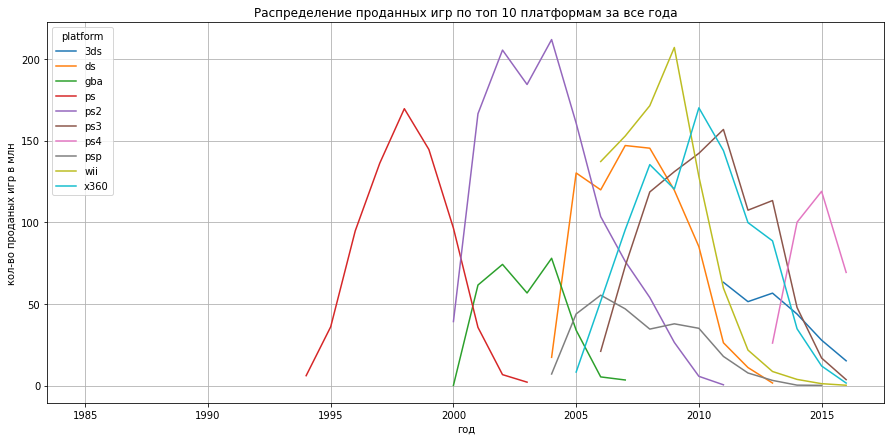

In [42]:
data[(data['platform'] == '3ds')| 
     (data['platform'] == 'psp')|
     (data['platform'] == 'gba')|
     (data['platform'] == 'ps4')|
     (data['platform'] == 'ps')|
     (data['platform'] == 'ds')|
     (data['platform'] == 'wii')|
     (data['platform'] == 'ps3')|
     (data['platform'] == 'x360')|
     (data['platform'] == 'ps2')].pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='total_sales', 
    aggfunc='sum').plot(grid=True, figsize=(15,7)).set_title('Распределение проданных игр по топ 10 платформам за все года')
plt.xlabel('год')
plt.ylabel('кол-во проданых игр в млн')
plt.show()

По распределению видно, на каждой консоли продажи начинались практически от нуля и, с ростом популярности платформы, росли и продажи игр, только wii отличается от всех, старт практически со 150 млн проданных игр. Этот график хорошо показывает, что каждая платформа первые несколько лет набирает продажи, а после пика продажи стремительно уменьшаются, стоит учитывать этот факт при построении дальнейших исследований.

### Теперь определин потенциально прибыльные (или не очень) платформы на 2017 год

Как было предложенно раньше, возьмём данные за период в 3 года по всем актуальным плафтормам и построим график распределения. Ожидаемо будет спад у платформ, которые вышли уже давно (кроме ПК), однако стоит взглянуть на их продажи, вдруг они будут не самыми плохими. 

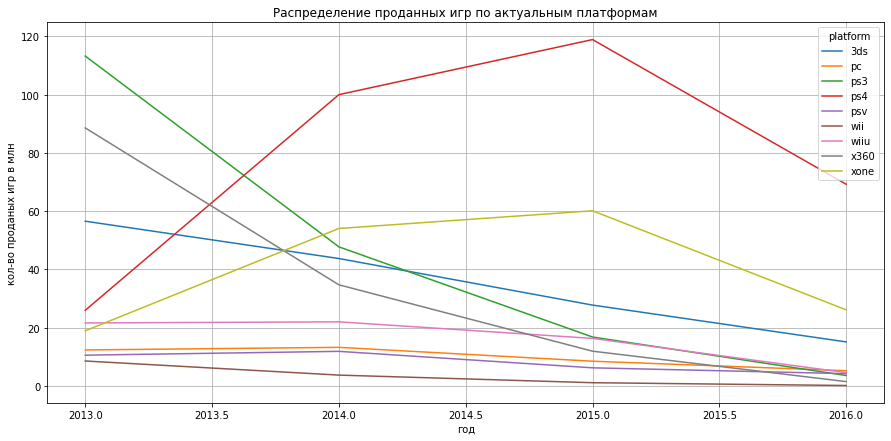

In [43]:
data_actual = data.query('2012 < year_of_release')
data_actual[(data_actual['platform'] == '3ds')| 
     (data_actual['platform'] == 'xone')|
     (data_actual['platform'] == 'x360')|
     (data_actual['platform'] == 'wiiu')|
     (data_actual['platform'] == 'wii')|
     (data_actual['platform'] == 'psv')|
     (data_actual['platform'] == 'ps4')|
     (data_actual['platform'] == 'ps3')|
     (data_actual['platform'] == 'pc')|
     (data_actual['platform'] == '3ds')].pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='total_sales', 
    aggfunc='sum').plot(grid=True, figsize=(15,7)).set_title('Распределение проданных игр по актуальным платформам')
plt.xlabel('год')
plt.ylabel('кол-во проданых игр в млн')
plt.show()

К сожалению, в 2016 у всех идёт спад, возможно по некоторым проектам данные ещё не окончательные. По многим платформам продажи очень маленькие и стремятся вниз стабильно, однако у PS 4 и Xbox One показывают неплохие продажи, ещё у 3DS есть почти 20 млн проданных игр, однако в 2016 году уже известно о nintendo switch и о том, что она выйдет в начале 2017 года полностью заменив собой 3DS, а судя по графику из 10 самых популярных платформ выход новой консоли компании очень сильно снижает продажи её предшественницы. В итоге потенциально прибыльными плафтормами предлагаю считать PS 4 и Xbox One.

### Построим диаграмму размаха  по глобальным продажам игр в разбивке по платформам

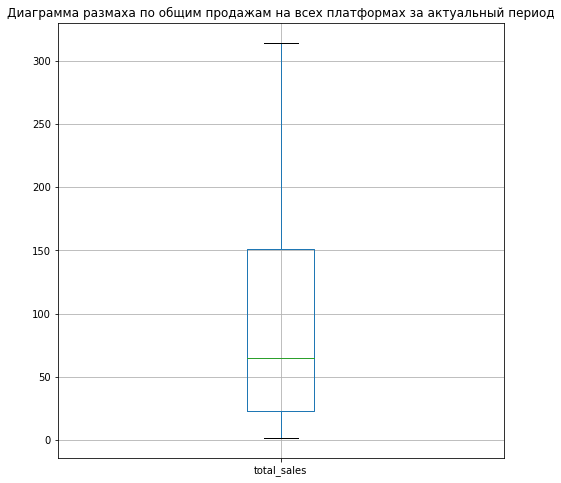

In [45]:
data_actual.pivot_table(index='platform', 
                        values='total_sales', 
                        aggfunc='sum').boxplot('total_sales', 
                                               figsize=(8, 8)).set_title(
    'Диаграмма размаха по общим продажам на всех платформах за актуальный период')
plt.show()

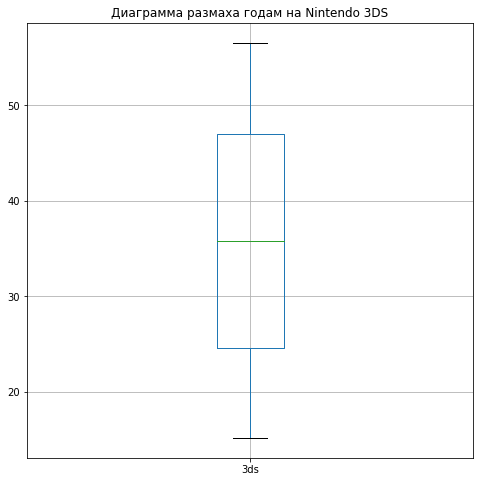

In [46]:
data_actual[(data_actual['platform'] == '3ds')].pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='total_sales', 
    aggfunc='sum').boxplot(figsize=(8, 8)).set_title(
    'Диаграмма размаха годам на Nintendo 3DS')
plt.show()

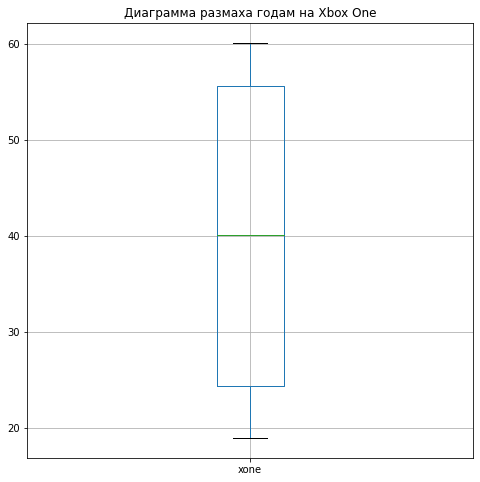

In [47]:
data_actual[(data_actual['platform'] == 'xone')].pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='total_sales', 
    aggfunc='sum').boxplot(figsize=(8, 8)).set_title(
    'Диаграмма размаха годам на Xbox One')
plt.show()

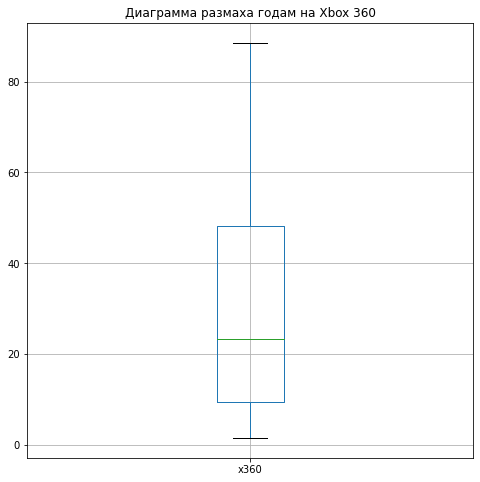

In [48]:
data_actual[(data_actual['platform'] == 'x360')].pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='total_sales', 
    aggfunc='sum').boxplot(figsize=(8, 8)).set_title(
    'Диаграмма размаха годам на Xbox 360')
plt.show()

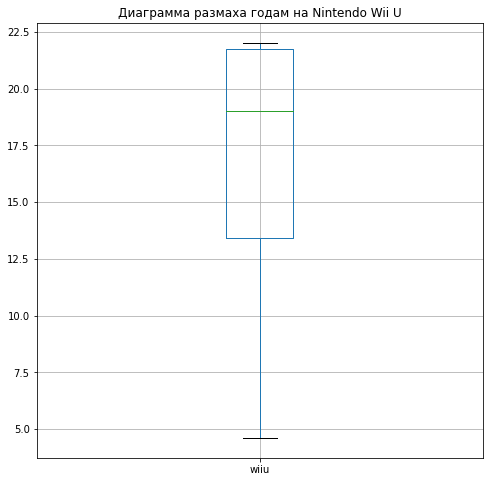

In [49]:
data_actual[(data_actual['platform'] == 'wiiu')].pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='total_sales', 
    aggfunc='sum').boxplot(figsize=(8, 8)).set_title(
    'Диаграмма размаха годам на Nintendo Wii U')
plt.show()

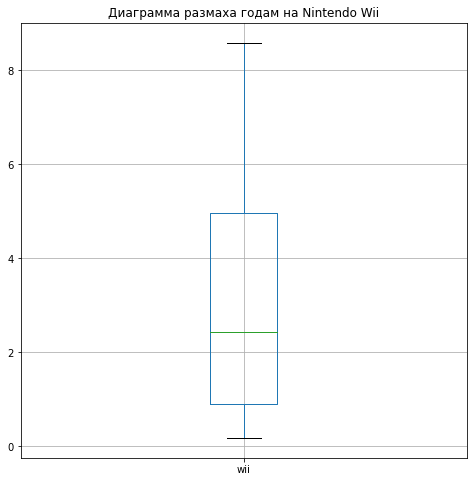

In [50]:
data_actual[(data_actual['platform'] == 'wii')].pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='total_sales', 
    aggfunc='sum').boxplot(figsize=(8, 8)).set_title(
    'Диаграмма размаха годам на Nintendo Wii')
plt.show()

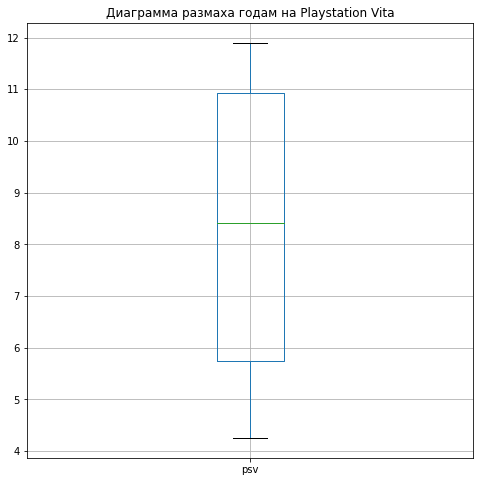

In [51]:
data_actual[(data_actual['platform'] == 'psv')].pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='total_sales', 
    aggfunc='sum').boxplot(figsize=(8, 8)).set_title(
    'Диаграмма размаха годам на Playstation Vita')
plt.show()

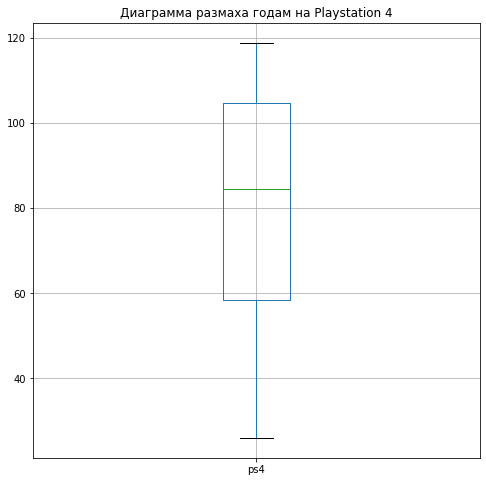

In [52]:
data_actual[(data_actual['platform'] == 'ps4')].pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='total_sales', 
    aggfunc='sum').boxplot(figsize=(8, 8)).set_title(
    'Диаграмма размаха годам на Playstation 4')
plt.show()

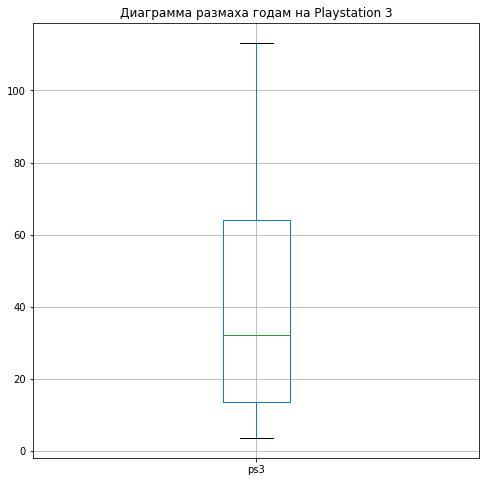

In [53]:
data_actual[(data_actual['platform'] == 'ps3')].pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='total_sales', 
    aggfunc='sum').boxplot(figsize=(8, 8)).set_title(
    'Диаграмма размаха годам на Playstation 3')
plt.show()

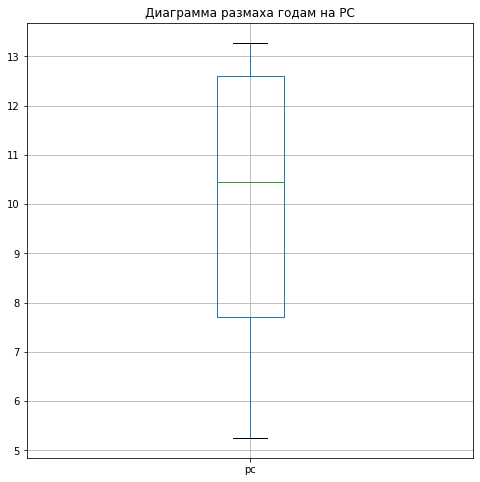

In [54]:
data_actual[(data_actual['platform'] == 'pc')].pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='total_sales', 
    aggfunc='sum').boxplot(figsize=(8, 8)).set_title(
    'Диаграмма размаха годам на PC')
plt.show()

Как видно по общему графику, в основном продажи колеблются в пределах 25 - 150 млн копий проданных игр. Однако есть сверхпопулярная среди всех платформа Sony Playstation 4, продажи на которой в среднем превышают 80 млн копий игр. К сожалению,у ближайших конкурентов, от Microsoft и Nintendo средние продажи более чем в 2 раза меньше.

### Предлагаю теперь посмотреть на то, как влияют отзывы на продажи игр внутри одной платформы, например PS 4.

In [55]:
data_actual_ps4 = data_actual.query('platform == "ps4"')
#переменная для более удобного кода

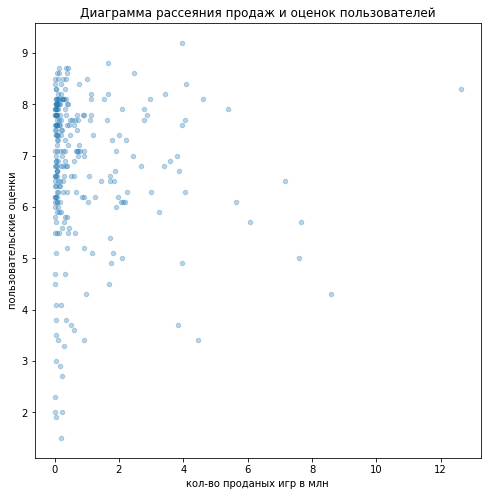

In [56]:
data_actual_ps4.plot(x='total_sales', 
                     y='user_score', 
                     kind='scatter', 
                     alpha=0.3, figsize=(8, 8)).set_title('Диаграмма рассеяния продаж и оценок пользователей')
plt.xlabel('кол-во проданых игр в млн')
plt.ylabel('пользовательские оценки')
plt.show()

In [57]:
data_actual_ps4['total_sales'].corr(data_actual_ps4['user_score'])
# корреляция продаж с оценками пользователей

-0.03195711020455639

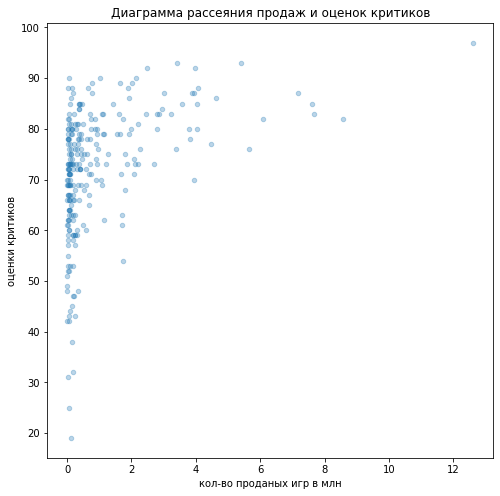

In [58]:
data_actual_ps4.plot(x='total_sales', 
                     y='critic_score', 
                     kind='scatter', 
                     alpha=0.3, figsize=(8, 8)).set_title('Диаграмма рассеяния продаж и оценок критиков')
plt.xlabel('кол-во проданых игр в млн')
plt.ylabel('оценки критиков')
plt.show()

In [59]:
data_actual_ps4['total_sales'].corr(data_actual_ps4['critic_score'])
# корреляция продаж с оценками критиков

0.406567902061781

И графики и корреляция говорят о том, что продажи практически никак не зависят от оценок пользвателей, получается либо люди играют и покупают то, что им не нравиться, либо занижают или завышают рейтинги по каким либо причинам. А вот оценки критиков действительно сказываются на продажах и, чем выше оценки, тем больше продаж будет у игры, самая высоко оценённая игра это подтверждает. Предлагаю взглянуть на неё и посмотреть, как обстоят дела на всех платформах сразу, а не только на одной.

In [60]:
data_actual.query('critic_score > 95')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,grand theft auto v,ps3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,grand theft auto v,x360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
165,grand theft auto v,xone,2014,action,2.81,2.19,0.00,0.47,97.0,7.9,M,5.47
1730,grand theft auto v,pc,2015,action,0.39,0.69,0.00,0.09,96.0,7.9,M,1.17


В целом, ожидаемо что это GTA 5, самая продаваемая игра на данный момент)

In [61]:
data_actual['total_sales'].corr(data_actual['critic_score'])
# корреляция продаж с оценками критиков на всех платформах

0.3136995151027371

In [62]:
data_actual['total_sales'].corr(data_actual['user_score'])
# корреляция продаж с оценками пользователей на всех платформах

-0.0026078133545982727

Корреляция на всех актуальных платформах сразу подтверждает предыдущие выводы, здесь чуть меньше зависимость продаж от оценок критиков, но она так же ощутима, а оценки пользователей всё так же не влияют на продажи. При построении прогноза лучше всего учитывать именно оценки экспертов.

Проверим корреляцию на остальных, самых популярных платформах по отдельности.

In [63]:
data_actual.query('platform == "xone"')['total_sales'].corr(data_actual['user_score'])
# корреляция продаж с оценками пользователей на Xbox One

-0.06892505328279412

In [64]:
data_actual.query('platform == "xone"')['total_sales'].corr(data_actual['critic_score'])
# корреляция продаж с оценками критиков на Xbox One

0.41699832800840186

In [65]:
data_actual.query('platform == "3ds"')['total_sales'].corr(data_actual['user_score'])
# корреляция продаж с оценками пользователей на Nintendo 3DS

0.24150411773563016

In [66]:
data_actual.query('platform == "3ds"')['total_sales'].corr(data_actual['critic_score'])
# корреляция продаж с оценками критиков на Nintendo 3DS

0.35705661422881035

Корреляция на Xbox приблизительно такая же, как у Sony, так же важны именно оценки критиков, а вот у 3DS корреляция продаж с оценками пользователей намного больше, чем у дрйгих, возможно это связано в целом с Японской культурой, а не с конкретной консолью, проверим это почитав корреляции в отдельных регионах.

In [67]:
data_actual['na_sales'].corr(data_actual['user_score'])
# корреляция продаж с оценками пользователей на всех платформах в Северной Америке

-0.020010136415148035

In [68]:
data_actual['na_sales'].corr(data_actual['critic_score'])
# корреляция продаж с оценками критиков на всех платформах в Северной Америке

0.3011299443114695

In [69]:
data_actual['eu_sales'].corr(data_actual['user_score'])
# корреляция продаж с оценками пользователей на всех платформах в Европе

-0.02703977307445156

In [70]:
data_actual['eu_sales'].corr(data_actual['critic_score'])
# корреляция продаж с оценками критиков на всех платформах в Европе

0.28078507833299765

In [71]:
data_actual['jp_sales'].corr(data_actual['user_score'])
# корреляция продаж с оценками пользователей на всех платформах в Японии

0.1940250994164801

In [72]:
data_actual['eu_sales'].corr(data_actual['critic_score'])
# корреляция продаж с оценками критиков на всех платформах в Японии

0.28078507833299765

Действительно, Япониские продажи больше зависят от пользовательских оценок, в отличии от остальных регионов.

### Посмотрим распределение продаж по жанрам.

In [73]:
genre_total_sales = data_actual.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count', 'mean'])
genre_total_sales.columns = ['total_sales', 'count_games', 'mean_sales']
genre_total_sales.sort_values('total_sales', ascending=False)

,total_sales,count_games,mean_sales
genre,,,
action,321.87,766,0.420196
shooter,232.98,187,1.245882
sports,150.65,214,0.703972
role-playing,145.89,292,0.499623
misc,62.82,155,0.405290
platform,42.63,74,0.576081
racing,39.89,85,0.469294
fighting,35.31,80,0.441375
adventure,23.64,245,0.096490


In [74]:
genre_total_sales.sort_values('mean_sales', ascending=False)

,total_sales,count_games,mean_sales
genre,,,
shooter,232.98,187,1.245882
sports,150.65,214,0.703972
platform,42.63,74,0.576081
role-playing,145.89,292,0.499623
racing,39.89,85,0.469294
fighting,35.31,80,0.441375
action,321.87,766,0.420196
misc,62.82,155,0.405290
simulation,21.76,62,0.350968


Как видно из приведённых таблиц, самым массовым жанром является action, у него же больше всех продаж в абсолюте, однако нельзя сказать что именно он самый прибольный, больше всех продаж в среднем приносят шутеры, более 1 млн проданых копий на игру.

## Портрет пользователя каждого региона

### Для начала посмотрим распределение платформ в каждом отдельном регионе

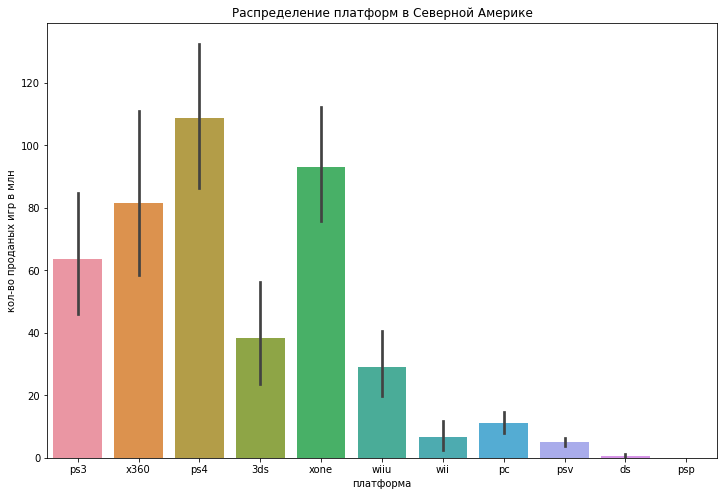

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=data_actual, 
            x='platform', 
            y='na_sales' , 
            estimator=np.sum,
            ax=ax).set_title('Распределение платформ в Северной Америке')
plt.xlabel('платформа')
plt.ylabel('кол-во проданых игр в млн')
plt.show()

In [76]:
na_sales_platform = data_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum')
na_sales_platform['share'] = na_sales_platform['na_sales'] / na_sales_platform['na_sales'].sum() * 100
na_sales_platform['share'].sort_values(ascending=False).head()
# Топ 5 платформ в процентном соотношении в Северной Америке

platform
ps4     24.842933
xone    21.274360
x360    18.656188
ps3     14.507322
3ds      8.727239
Name: share, dtype: float64

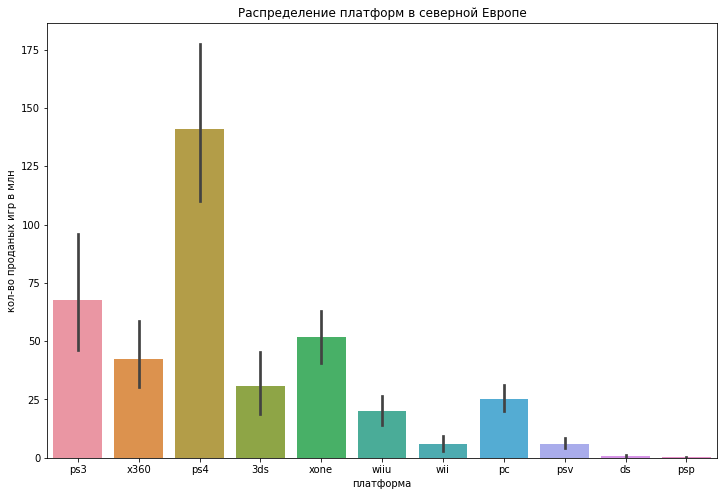

In [77]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=data_actual, 
            x='platform', 
            y='eu_sales' , 
            estimator=np.sum,
            ax=ax).set_title('Распределение платформ в северной Европе')
plt.xlabel('платформа')
plt.ylabel('кол-во проданых игр в млн')
plt.show()

In [78]:
eu_sales_platform = data_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
eu_sales_platform['share'] = eu_sales_platform['eu_sales'] / eu_sales_platform['eu_sales'].sum() * 100
eu_sales_platform['share'].sort_values(ascending=False).head()
# Топ 5 платформ в процентном соотношении в Европе

platform
ps4     35.971241
ps3     17.288326
xone    13.152997
x360    10.840578
3ds      7.893328
Name: share, dtype: float64

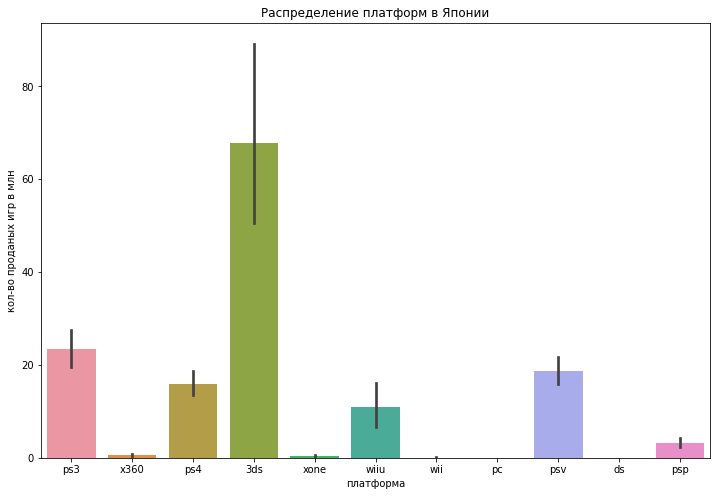

In [79]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=data_actual, 
            x='platform', 
            y='jp_sales' , 
            estimator=np.sum,
            ax=ax).set_title('Распределение платформ в Японии')
plt.xlabel('платформа')
plt.ylabel('кол-во проданых игр в млн')
plt.show()

In [80]:
jp_sales_platform = data_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
jp_sales_platform['share'] = jp_sales_platform['jp_sales'] / jp_sales_platform['jp_sales'].sum() * 100
jp_sales_platform['share'].sort_values(ascending=False).head()
# Топ 5 платформ в процентном соотношении в Европе

platform
3ds     48.167353
ps3     16.586163
psv     13.205001
ps4     11.336838
wiiu     7.728371
Name: share, dtype: float64

По графикам и процентным соотношениям видно, что Северная Америка и Европа в целом похожи, лидируют продажи на PS 4 25% и 36%, отличаются немного вторые места, Xboxe One 21% и PS 3 17% соответственно, однако, поскольку продажи у PS 3 падают, больше внимания всё же стоит уделять именно Xbox One не только в Северной Америке, но и в Европе. Сильно отличается от них Япония, почти половина рынка это портативная консоль Nintendo 3DS, а популярная везде Playstation 4 аж на 4 месте с 11% долей рынка, хдесь больше внимания стоит уделить именно играм на портативной консоли от Nintendo. Япония в целом своеобразная страна в плане игр, думаю и распределение жанров там будет отличаться)

### Теперь можем посмотреть на распределение жанров

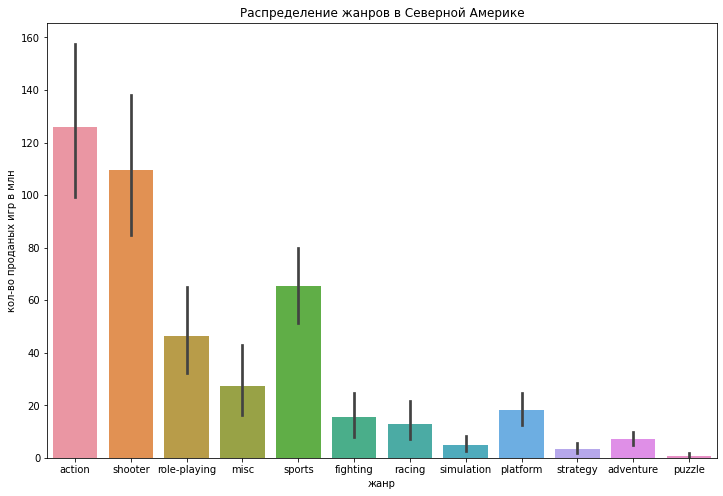

In [81]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=data_actual, 
            x='genre', 
            y='na_sales' , 
            estimator=np.sum,
            ax=ax).set_title('Распределение жанров в Северной Америке')
plt.xlabel('жанр')
plt.ylabel('кол-во проданых игр в млн')
plt.show()

In [82]:
na_sales_genre = data_actual.pivot_table(index='genre', values='na_sales', aggfunc='sum')
na_sales_genre['share'] = na_sales_genre['na_sales'] / na_sales_genre['na_sales'].sum() * 100
na_sales_genre['share'].sort_values(ascending=False).head()
# Топ 5 жанров в процентном соотношении в Северной Америке

genre
action          28.797606
shooter         25.071394
sports          14.911700
role-playing    10.600626
misc             6.280414
Name: share, dtype: float64

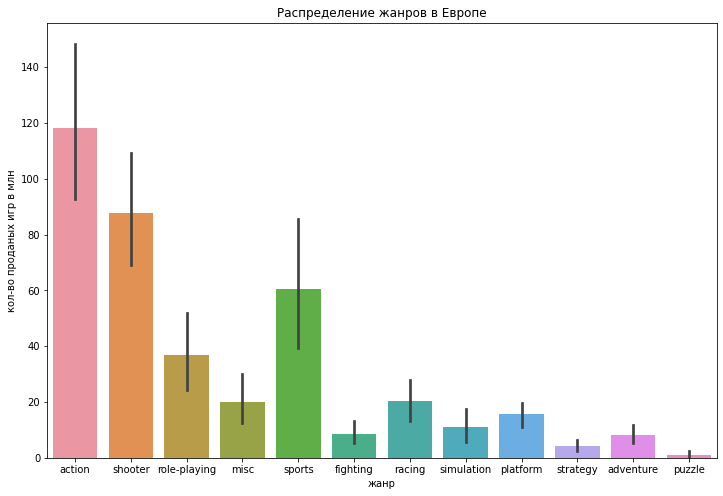

In [83]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=data_actual, 
            x='genre', 
            y='eu_sales' , 
            estimator=np.sum,
            ax=ax).set_title('Распределение жанров в Европе')
plt.xlabel('жанр')
plt.ylabel('кол-во проданых игр в млн')
plt.show()

In [84]:
eu_sales_genre = data_actual.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
eu_sales_genre['share'] = eu_sales_genre['eu_sales'] / eu_sales_genre['eu_sales'].sum() * 100
eu_sales_genre['share'].sort_values(ascending=False).head()
# Топ 5 жанров в процентном соотношении в Европе

genre
action          30.117533
shooter         22.400122
sports          15.429722
role-playing     9.425592
racing           5.147490
Name: share, dtype: float64

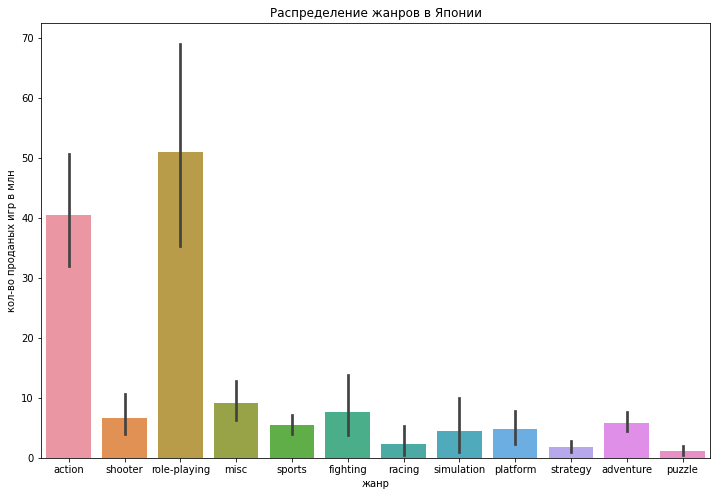

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=data_actual, 
            x='genre', 
            y='jp_sales' , 
            estimator=np.sum,
            ax=ax).set_title('Распределение жанров в Японии')
plt.xlabel('жанр')
plt.ylabel('кол-во проданых игр в млн')
plt.show()

In [86]:
jp_sales_genre = data_actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
jp_sales_genre['share'] = jp_sales_genre['jp_sales'] / jp_sales_genre['jp_sales'].sum() * 100
jp_sales_genre['share'].sort_values(ascending=False).head()
# Топ 5 жанров в процентном соотношении в Японии

genre
role-playing    36.255150
action          28.761188
misc             6.535019
fighting         5.434011
shooter          4.695269
Name: share, dtype: float64

По жанрам мы можем заметить всё то же сходство Северной Амирики и Европы, лидируют экшены и шутеры, и там и там у лидера примерно 30%. Япония отличается, здесь значительный вес имеют только ролевые игры с 36% и экшены с 29%, остальные жанры по всей видимости не очень интересны японии, на все остальные жанры приходиться 35% проданных игр, меньше, чем у лидера.

### Посмотрим на различия в рейтинге игр по ESRB

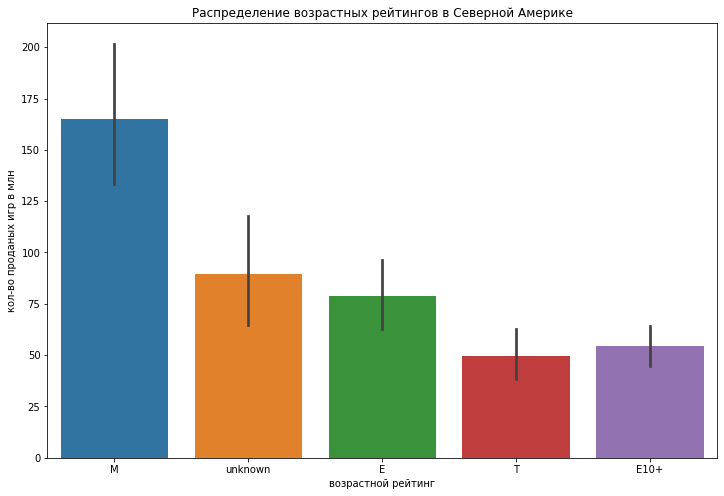

In [87]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=data_actual, 
            x='rating', 
            y='na_sales' , 
            estimator=np.sum,
            ax=ax).set_title('Распределение возрастных рейтингов в Северной Америке')
plt.xlabel('возрастной рейтинг')
plt.ylabel('кол-во проданых игр в млн')
plt.show()

In [88]:
na_sales_rating = data_actual.pivot_table(index='rating', values='na_sales', aggfunc=['sum', 'count'])
na_sales_rating.columns = ['total_sales', 'count_games']
na_sales_rating['mean_sales'] = na_sales_rating['total_sales'] / na_sales_rating['count_games']
na_sales_rating['mean_sales'].sort_values(ascending=False)
# Средние продажи игр с разными рейтингами в Северной Америке

rating
M          0.447724
E          0.261755
E10+       0.215238
T          0.149520
unknown    0.091525
Name: mean_sales, dtype: float64

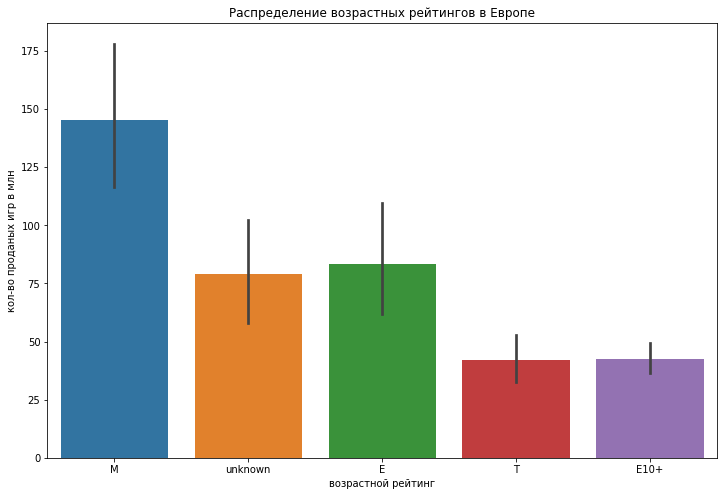

In [89]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=data_actual, 
            x='rating', 
            y='eu_sales' , 
            estimator=np.sum,
            ax=ax).set_title('Распределение возрастных рейтингов в Европе')
plt.xlabel('возрастной рейтинг')
plt.ylabel('кол-во проданых игр в млн')
plt.show()

In [90]:
eu_sales_rating = data_actual.pivot_table(index='rating', values='eu_sales', aggfunc=['sum', 'count'])
eu_sales_rating.columns = ['total_sales', 'count_games']
eu_sales_rating['mean_sales'] = eu_sales_rating['total_sales'] / eu_sales_rating['count_games']
eu_sales_rating['mean_sales'].sort_values(ascending=False)
# Средние продажи игр с разными рейтингами в Европе

rating
M          0.393821
E          0.276026
E10+       0.169405
T          0.125976
unknown    0.080768
Name: mean_sales, dtype: float64

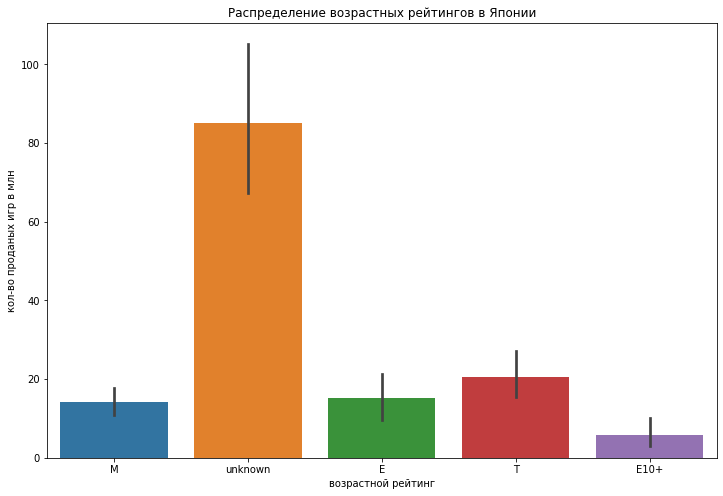

In [91]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=data_actual, 
            x='rating', 
            y='jp_sales' , 
            estimator=np.sum,
            ax=ax).set_title('Распределение возрастных рейтингов в Японии')
plt.xlabel('возрастной рейтинг')
plt.ylabel('кол-во проданых игр в млн')
plt.show()

In [92]:
jp_sales_rating = data_actual.pivot_table(index='rating', values='jp_sales', aggfunc=['sum', 'count'])
jp_sales_rating.columns = ['total_sales', 'count_games']
jp_sales_rating['mean_sales'] = jp_sales_rating['total_sales'] / jp_sales_rating['count_games']
jp_sales_rating['mean_sales'].sort_values(ascending=False)
# Средние продажи игр с разными рейтингами в Японии

rating
unknown    0.087052
T          0.061832
E          0.050132
M          0.038238
E10+       0.023373
Name: mean_sales, dtype: float64

Различия всё те же, что и раньше)
В Северной Америке и Европе больше всего проданных игр и больше всего продаж в среднем на 1 игру приходится на рейтинг M (17+) намного больше 100 млн проданных игр в целом и около 400 тысяч в среднем, на втором месте, с серьёхным отстованием рейтинг E (для всех возрастов) чуть менее 100 млн проданных игр и около 270 тысяч копий в среднем. Япония же отличается именно лидером, тут больше всего проданных игр с рейтингом T (13+), чуть более 20 млн и 60 тысяч в среднем, второе место у рейтинга E, 15 млн в сумме и 50 тысяч в среднем продаж. Так же стоит отметить, что у достаточно большого количества игр отсутствует возрастной рейтинг, особенно это заметно в Японии, где неизвестный рейтинг занимает основную долю рынка, вероятнее всего это связано с тем, что ESRB компания из США и специализируется только на выпускаемых или выходящих там играх, а в Японии существует очень много эксклюивных игр, выходящих только в одной стране. Предлагаю всё же брать игры с известным рейтингом для выводов, поскольку неизвестный рейтинг достатчно сложно правильно оценить, вероятно в Японии есть своя система возрастных оценок и для более точного анализа неоходимо больше данных.

### Пользователь каждого региона

В целом, можно сказать, что пользователи Северной Америки и Европы очень похожи, пользователь вероятнее всего придёт в магазин за игрой жанра экшен для Playstation 4 с возрастным рейтингом M по ESRB, а Японский пользователь придёт за ролевой игрой для 3DS с рейтингом T.

## Проверка гипотиз

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

```
H_0: средние пользовательские рейтинги Xbox One = средние пользовательские рейтинги PC
H_a: средние пользовательские рейтинги Xbox One ≠ средние пользовательские рейтинги PC
alpha = 0.05
```

In [93]:
data_actual_pc = data_actual.query('platform == "pc"')
data_actual_pc = data_actual_pc['user_score'].dropna()
data_actual_xone = data_actual.query('platform == "xone"')
data_actual_xone = data_actual_xone['user_score'].dropna()
# Проверяем только заполненные значения
print(len(data_actual_pc))
print(len(data_actual_xone))

155
182


In [94]:
alpha = 0.05
results = st.ttest_ind(data_actual_pc, data_actual_xone, equal_var=False)
# equal_var = False, поскольку выборки по размеру примерно одинаковы
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')  

0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


Гипотеза о том, что средние пользовательские рейтинги на Xbox One и ПК одинаковые верна, они действительно очень схожи.

### Средние пользовательские рейтинги жанров Action и Sports разные.

```
H_0: cредние пользовательские рейтинги Action ≠ средние пользовательские рейтинги Sports
H_a: средние пользовательские рейтинги Action = средние пользовательские рейтинги Sports
alpha = 0.05
```

In [95]:
data_actual_action = data_actual.query('genre == "action"')
data_actual_action = data_actual_action['user_score'].dropna()
data_actual_sports = data_actual.query('genre == "sports"')
data_actual_sports = data_actual_sports['user_score'].dropna()
# Проверяем только заполненные значения
print(len(data_actual_action))
print(len(data_actual_sports))

389
160


In [96]:
alpha = 0.05
results = st.ttest_ind(data_actual_action, data_actual_sports, equal_var=True)
# equal_var = True, поскольку выборки по размеру разные
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')  

1.0517832389140023e-27
Отвергаем нулевую гипотезу


Гипотезу о том, что средние пользовательские рейтинги жанров экшен и спорт разные можно отвергнуть, они достаточно близки друг к другу. При изменении параметра alpha результат проверок не будет отличаться.

## Общий вывод

```
Начнём с исходного датасета. В таблице были пропущены некоторые значения в названии игр, дате их выхода и жанров, данные пропуски пришлось удалить, поскольку заменить их логически невозможно и их было немного, так что на общий вывод они не могли повлиять. 
Так же пропуски были в столбцах с пользовательским рейтингом, оценками критикиков, было принято не заполнять данные пропуски и не удалять их, поскольку это около половины всех данных, а заполнить их медианным или средним значениями не совсем корректно, ведь рейтинг у игры складывается от независимых в данных параметров, таких как геймплей, сюжет и тому подобное. В возрастном рейтинге игр было принято заменить пропуски на значение "unknown" для учёта этих игр в исследованиях.
```

```
Общий вывод по исследованию. В данных представлено очень большое количтсво игр, большинство из которых вышли после 2000 года, самый пик был в 2009 - 2010 годах, после чего началось падение и только в 2016 году игр снова стало выходить больше, чем в предыдущем году. 
Средний срок жизни платформы составляет в среднем 6 лет, если не брать в расчёт ПК, однако он постоянно обновляется и эволюционирует, из-за чего сравнивать его с консолями не корректно, при этом, со столь долгой жизнью в 31 год он не смог стать наиболее популярной платформой среди всех, вероятно это связано с тем, что в данных учитаны только продажи на физических носителях, по этому показателю и новым платформам будет очень сложно угнаться за абсолюным лидером Playstation 2 c 1.2 млрд проданных копий игр. 
Среди современных платформ стоит отметить Playstation 4, Xbox One и Nintendo 3DS, первая является лидером по продажам игр в Северной Америке и Европе с более чем 250 млн проданных игр в этих регионах, а последняя является лидеромс в Японии с 60 млн проданных игр.
Самыми популярными жанрами сейчас являются Action в каждом из регионов, а так же Shopter и Sports в Европе и Северной Америке и Role-play в Японии, а наиболее популярными рейтингами: M во всех регионах, а так же T и E в Японии.
В ходе исследования было проверено две гипозы и получены следующие результаты: средние пользовательские рейтинги платформ Xbox One и PC и Средние пользовательские рейтинги жанров Action и Sports одинаковые.
```

```
Рекомендации к планироанию рекламных кампаний
На продажи игр достаточно сильно влияют оценки критиков, поэтому больше внимания стоит уделить именно играм с высокими оценками экспертов, при этом можно не удять много внимая на пользовательские оценки, поскольку они не влияют на продажи проекта.
В Северной Америке и Европе больше внимания стоит уделить играм на консоли Playstation 4 и меньше Xbox One, первая показывает лучшие продажи среди всех актуальных платформ. В Японии же больше всего внимания стоит уделить портативной консоли Nintendo, поскольку у них выходит новая Nintendo Switch больше внимания стоит уделить именно ей, а не 3DS, по графикам заметно резкое падения продаж игр на старой консоли при выходе новой.
Наиболее успешными будут Action, вышедшие на Playstation 4 с возрастным рейтингом M и максимально возможными оценками критиков В Северной Америке и Европе и Role-play игры для Nintendo с возрастным рейтингом T в Японии.
Выводы основаны на данных за последние 3 года.
```